<a href="https://colab.research.google.com/github/adrianleung60/CalgaryCrime/blob/main/Calgary_Crime_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install plotly==4.14.3

     |████████████████████████████████| 13.2MB 8.5MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
pip install --upgrade statsmodels

     |████████████████████████████████| 9.5MB 5.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import datetime
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, DatePicker
sns.set()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Import and Transformation

In [ ]:
#@title Import geojson
from urllib.request import urlopen
import json

with urlopen('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/calgary.geojson') as response:
  geojson = json.load(response)

In [ ]:
#@title Import and transform data

# Importing and transforming dataset 2015-2020
df = pd.read_csv('/content/drive/MyDrive/2020 Calgary Community Crime Stats.csv')
df.dropna(subset=['Community'], inplace=True) #drop blank rows in between communities
df.fillna(0, inplace=True) #replace blank data with 0

# Transform dataframe with crime categories as columns

for x in df['Community'].unique():

  dftrans = df[df['Community'] == x] #filter out data for just community
  dftrans = dftrans.iloc[:,1:df.shape[1]] # take only columns from category and dates to transpose
  dftrans.set_index('Category', inplace=True) # remove index for transpose
  dftrans.index.name=None # remove index name
  dftrans = dftrans.T # transpose
  dftrans.insert(0, 'Community', x) # insert column for community
  dftrans.index.name='Date' #rename index    

  if x == df['Community'][0]:
    bigdf1 = pd.DataFrame(columns=dftrans.columns)

  bigdf1 = pd.concat((bigdf1, dftrans))

bigdf1.rename(columns={bigdf1.columns[4]:'Violence (Non-domestic)'}, inplace=True)

# Combine Categories 
bigdf1['B&E Crimes Total'] = bigdf1['Break & Enter - Dwelling'] + bigdf1['Break & Enter - Commercial'] + bigdf1['Break & Enter - Other Premises']
bigdf1['Vehicle Crimes Total'] = bigdf1['Theft OF Vehicle'] + bigdf1['Theft FROM Vehicle'] 
bigdf1['Other Crimes Total'] = bigdf1['Assault (Non-domestic)'] + bigdf1['Commercial Robbery'] + bigdf1['Street Robbery'] + bigdf1['Violence (Non-domestic)']
bigdf1['Total Crimes'] = bigdf1['B&E Crimes Total'] + bigdf1['Vehicle Crimes Total'] + bigdf1['Other Crimes Total']
bigdf1['Total Disorders'] = bigdf1['Physical Disorder'] + bigdf1['Social Disorder']

#convert dates
year = []
month = []

for i, row in bigdf1.iterrows():
  date_time_obj = datetime.datetime.strptime(i, '%b %Y')
  year.append(date_time_obj.year)
  month.append(date_time_obj.month)

bigdf1['YEAR'] = year
bigdf1['MONTH'] = month
bigdf1['DATE'] = pd.to_datetime(bigdf1[['YEAR', 'MONTH']].assign(DAY=1))

#Reorder
order = ['DATE','YEAR', 'MONTH', 'Community', 'Total Crimes', 'Total Disorders', 'B&E Crimes Total', 'Vehicle Crimes Total', 'Other Crimes Total']
new_cols = order + (bigdf1.columns.drop(order).tolist())
bigdf1 = bigdf1[new_cols]

bigdf1['Community'] = bigdf1['Community'].str.title()
bigdf1.set_index('DATE', drop=True, inplace=True)

#----------------------------------------------------------

# Importing and transforming extended dataset 2012-2014
# source: https://data.calgary.ca/Health-and-Safety/Community-Crime-and-Disorder-Statistics-to-be-arch/848s-4m4z
df2 = pd.read_csv('/content/drive/MyDrive/statsarchived.csv')

df2.sort_values(by='Community Name', inplace=True)
df2 = df2[df2['Community Name'].str[0].str.isdigit() == False]

#drop years before 2015
df2 = df2[df2['Year'] < 2015]

for x in df2['Category'].unique():
  df2[x] = 0

for i, rows in df2.iterrows():
  count = df2.at[i,'Crime Count']
  category = df2.at[i,'Category']
  df2.at[i, category] = count

df2['Date'] = pd.to_datetime(df2['Date']).dt.normalize()

df2.set_index('Date', drop=True, inplace=True)

for x in df2['Community Name'].unique():
  dftrans = df2[df2['Community Name'] == x]
  dftrans = dftrans.iloc[:,10:dftrans.shape[1]]
  dftrans = dftrans.groupby(dftrans.index).sum()
  dftrans.insert(0, 'Community', x)

  if x == df2['Community Name'][0]:
    bigdf2 = pd.DataFrame(columns=dftrans.columns)

  bigdf2 = pd.concat((bigdf2, dftrans))

bigdf2['Community'] = bigdf2['Community'].str.title()

bigdf2.rename(columns={'Residential Break & Enter':'Break & Enter - Dwelling',
                    'Commercial Break & Enter': 'Break & Enter - Commercial',
                    'Violence Other (Non-domestic)':'Violence (Non-domestic)'}, inplace=True)

# Combine Categories 
bigdf2['B&E Crimes Total'] = bigdf2['Break & Enter - Dwelling'] + bigdf2['Break & Enter - Commercial'] 
bigdf2['Vehicle Crimes Total'] = bigdf2['Theft OF Vehicle'] + bigdf2['Theft FROM Vehicle'] 
bigdf2['Other Crimes Total'] = bigdf2['Assault (Non-domestic)'] + bigdf2['Commercial Robbery'] + bigdf2['Street Robbery'] + bigdf2['Violence (Non-domestic)']
bigdf2['Total Crimes'] = bigdf2['B&E Crimes Total'] + bigdf2['Vehicle Crimes Total'] + bigdf2['Other Crimes Total']
bigdf2['Total Disorders'] = bigdf2['Physical Disorder'] + bigdf2['Social Disorder']

#add dates
year = []
month = []

for i, row in bigdf2.iterrows():
  year.append(i.year)
  month.append(i.month)

bigdf2['YEAR'] = year
bigdf2['MONTH'] = month

bigdf2.index.name='DATE'

#----------------------------------------------------------

# Combining two datasets
bigdf = pd.concat([bigdf1, bigdf2])
bigdf.sort_values(['Community','YEAR','MONTH'], inplace=True)

bigdf.head()

YEAR  MONTH  ... Social Disorder Physical Disorder
DATE                     ...                                  
2012-01-01  2012      1  ...              29                 4
2012-02-01  2012      2  ...              22                 1
2012-03-01  2012      3  ...              21                 5
2012-04-01  2012      4  ...              29                 3
2012-05-01  2012      5  ...              28                 3

[5 rows x 19 columns]

In [ ]:
bigdf.index.min(), bigdf.index.max()

(Timestamp('2012-01-01 00:00:00'), Timestamp('2020-12-01 00:00:00'))

In [ ]:
bigdf['Community'].nunique()

259

# Data Description
Calgary Police Services Total Crimes category is calculated from the sum of:

1) Break and Enters (dwelling, commercial, and other premises)

2) Vehicle Crimes (Theft of vehicles and Theft from vehicles)

3) Other Crimes (assaults (non-domestic), commercial robberies, street robberies, and non-domestic 'other' violence)



In addition, there is a 'disorders' category, which is a sum of physical and social disorders. This category is separate from actual criminal activity and are activities highly visible and in public spaces. Examples include drunks, panhandling, youth gangs, prostitution, littering, loitering, and graffiti. 


Frequency of data is monthly sums with time range spanning 8 years (Jan 2012 - Dec 2020). Data is segregated between 259 communities around Calgary.

In [ ]:
neighbourhoodlist = bigdf['Community'].unique()
timelist = bigdf.index.unique()
timelist = pd.to_datetime(timelist)
timelist = timelist.sort_values(ascending=False)

# Dashboard for initial look at Crime Data

In [ ]:
#@title Functions for updating charts

def neighbourhoodtrends(x):

  dfneighbourhood = bigdf[bigdf['Community'] == x]
  fig = make_subplots(rows=1, cols=2, subplot_titles=('Total Crimes', 'Total Disorders'))

  fig.add_trace(go.Scatter(x=dfneighbourhood.index, y=dfneighbourhood['Total Crimes'],
                           line=dict(color='red')
                           ),1,1,)
  fig.add_trace(go.Scatter(x=dfneighbourhood.index, y=dfneighbourhood['Total Disorders'],
                           line=dict(color='blue')
                           ),1,2)

  fig.update_layout(height=600, width=1600, title_text=x, showlegend=False)

  return fig

def choroplethcrime(x):

  testdf = bigdf[bigdf.index == x]

  fig = make_subplots(rows=1, cols=2,specs=[[{'type': 'mapbox'},{'type': 'mapbox'}]], 
                      subplot_titles=('Total Crimes', 'Total Disorders'),
                      horizontal_spacing=0.15
                      )

  p1 = np.percentile(testdf['Total Crimes'],95)
  p2 = np.percentile(testdf['Total Disorders'],95)

  fig.add_traces(go.Choroplethmapbox(geojson=geojson, locations=testdf['Community'], z=testdf['Total Crimes'],
                                     zmin=0, zmax=p1,
                                     colorscale="OrRd",featureidkey='properties.name',
                                     colorbar_x=0.45,
                                     marker_opacity=0.5,showlegend=True),1,1)
  
  fig.add_traces(go.Choroplethmapbox(geojson=geojson, locations=testdf['Community'], z=testdf['Total Disorders'],
                                     zmin=0, zmax=p2,
                                     colorscale="Blues",featureidkey='properties.name',
                                     marker_opacity=0.5,showlegend=True),1,2)

  fig.update_layout(mapbox_style="open-street-map", 
                    mapbox_zoom=10, 
                    mapbox_center = {"lat": 51.033, "lon": -114.105},
                    mapbox2_style="open-street-map",
                    mapbox2_zoom=10,
                    mapbox2_center = {"lat": 51.033, "lon": -114.105},
                    )
  
  title = pd.to_datetime(x)
  fig.update_layout(height=800, width=1600,
                  showlegend=False, title_text=str(title.strftime('%b')) +" "+ str(title.year))

  return fig

In [ ]:
#@title Calgary Crime Snapshot
interact(choroplethcrime, x=timelist)

interactive(children=(Dropdown(description='x', options=(Timestamp('2020-12-01 00:00:00'), Timestamp('2020-11-…

<function __main__.choroplethcrime>

Using plotly dash and geojson, we can visualize 'hot spots' for crime and disorders around Calgary.

In [ ]:
#@title Calgary Crime and Disorders since 2012
dftotal = bigdf[['Total Crimes', 'Total Disorders']]
dftotal = dftotal.groupby(dftotal.index).sum()

fig = make_subplots(rows=1, cols=2, subplot_titles=('Total Crimes', 'Total Disorders'))

fig.add_trace(go.Scatter(x=dftotal.index, y=dftotal['Total Crimes'],
                         line=dict(color='red')
                         ),1,1)
fig.add_trace(go.Scatter(x=dftotal.index, y=dftotal['Total Disorders'],
                         line=dict(color='blue')
                         ),1,2)

fig.update_layout(height=600, width=1600, title_text="Calgary Crime and Disorders",
                  showlegend=False)

fig.show()

Aggregate data over time shows seasonal trends in the data in both crime and disorders. While we can see a noticeable step change in total crimes since 2015, the increase in total disorders appears more gradual. 

In [ ]:
#@title Neighbourhood Trends
interact(neighbourhoodtrends, x=neighbourhoodlist)

interactive(children=(Dropdown(description='x', options=('Abbeydale', 'Acadia', 'Albert Park/Radisson Heights'…

<function __main__.neighbourhoodtrends>

# Decomposition of Time Series

In [ ]:
# Import models for time series modelling
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
from itertools import cycle

In [ ]:
#@title decompose(ts) - function for decomposing and visualizing a time series

def decompose(ts):

  palette = cycle(px.colors.qualitative.G10)

  decompose = seasonal_decompose(ts, model='additive')
  fig = make_subplots(2,2, subplot_titles=('Observed','Trend','Seasonal','Residual'))
  fig.add_trace(go.Scatter(x=decompose.observed.index,y=decompose.observed,
                           marker_color=next(palette)),1,1)
  fig.add_trace(go.Scatter(x=decompose.trend.index,y=decompose.trend,
                           marker_color=next(palette)),1,2)
  fig.add_trace(go.Scatter(x=decompose.seasonal.index,y=decompose.seasonal,
                           marker_color=next(palette)),2,1)
  fig.add_trace(go.Scatter(x=decompose.resid.index,y=decompose.resid,
                           marker_color=next(palette)),2,2)
  fig.update_layout(width=800, title_text=ts.name)
  fig.show()

In [ ]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit(start_ar_lags = 11).llf
    L2 = mod_2.fit(start_ar_lags = 11).llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [ ]:
dftotal_ts = bigdf[['Total Crimes', 'Total Disorders']]
dftotal_ts = dftotal_ts.groupby(dftotal_ts.index).sum()
dftotal_ts = dftotal.asfreq('MS')

dftotal_ts.head()

Total Crimes  Total Disorders
DATE                                     
2012-01-01        1378.0           5425.0
2012-02-01        1338.0           5499.0
2012-03-01        1623.0           6520.0
2012-04-01        1604.0           6764.0
2012-05-01        1617.0           7249.0

Data is transformed into time series format with a monthly frequency and date index. Total crimes and total disorders are the main categories for the time series analysis of Calgary's crime trends. 

In [ ]:
#@title Decomposition Analysis
decompose(dftotal_ts['Total Crimes'])

General Trend (red) - we can see crime has been relatively flat between 2012 to 2014, with a noticeable increase up until late 2019. Calgary police attributes the initial increase in 2014 with the the energy downturn as well as an influx of highly addictive drugs intot he city and crime associated with it. 

https://www.cbc.ca/news/canada/calgary/canada-crime-stats-rate-increase-statistics-canada-severity-index-police-1.3686871

Seasonal Trend (yellow) - While we can see fluctuations in the data (blue), a seasonal decomposition gives us a clearer picture behind the data. Calgary sees low's in February and highs in July, with a difference in 680 reported crimes between each month. This can probably be correlated with weather - where criminal activity tends to be lower in colder months and higher in the warmer summer months. 

Residuals (green) - This is the remaining data that cannot be explained by either a general or seasonal trend. While this appears to be random, it does represent a significant amount of data (+/- 500 crimes) and cannot be ignored. we can further break down using other statistical techniques.

From the histogram and QQ plot, we can see that data it is roughly normally distributed (bell shaped) with a mean close to zero and a standard deviation of 197 crimes.


In [ ]:
residual = seasonal_decompose(dftotal_ts['Total Crimes']).resid
residual.dropna(inplace=True)
residual.describe()

count     96.000000
mean      -2.740017
std      196.917412
min     -728.031684
25%      -91.331163
50%        8.447483
75%       97.413628
max      460.577691
Name: resid, dtype: float64

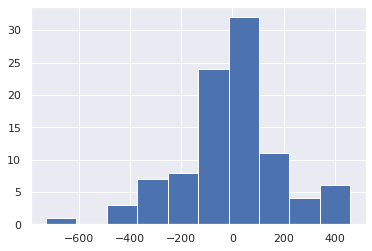

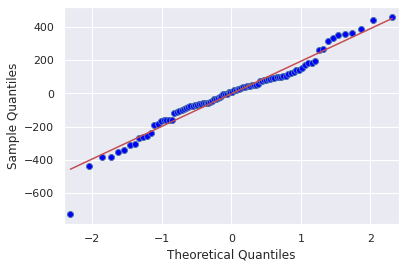

In [ ]:
plt.hist(residual)
qqplot(residual, line='s').gca().lines

# Time Series Analysis

In [ ]:
#@title test_stationarity(ts) - function for testing stationarity of a time series

def test_stationarity(ts):

  # remove nans
  ts.dropna(inplace=True)

  # determine rolling average
  movingAvg = ts.rolling(window=12).mean()
  movingSTD = ts.rolling(window=12).std()

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=ts.index, y=ts, name='Time Series'))
  fig.add_trace(go.Scatter(x=ts.index, y=movingAvg, name='Rolling Avg'))
  fig.add_trace(go.Scatter(x=ts.index, y=movingSTD, name='Rolling Std'))
  fig.update_layout(width=800, title_text='Stationarity Test for ' + str(ts.name))
  fig.show()

  print('Results of Dicky-Fuller Test:')
  dftest = sts.adfuller(ts)
  dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '# Lags Used', '# Observations Used'])
  print(dfoutput)

  if dftest[1] < 0.05:
    print('Time Series is stationary (@ 5%)')
  else:
    print('Time Series is non-stationary (@ 5%)')

In [ ]:
#@title Data Transformation
test_stationarity(dftotal_ts['Total Crimes'])

Results of Dicky-Fuller Test:
Test Statistic         -1.616275
p-value                 0.474683
# Lags Used            12.000000
# Observations Used    95.000000
dtype: float64
Time Series is non-stationary (@ 5%)


Testing stationarity of the total crimes trend to no surprise is non-stationary data given the increase in 2014. We will need to transform the data to a stationary form.

In [ ]:
# First difference transformation
dftotal_ts['Total Crimes Diff'] = dftotal_ts['Total Crimes'].diff(1).dropna()
test_stationarity(dftotal_ts['Total Crimes Diff'])

Results of Dicky-Fuller Test:
Test Statistic         -2.946449
p-value                 0.040207
# Lags Used            11.000000
# Observations Used    95.000000
dtype: float64
Time Series is stationary (@ 5%)


Using first difference transforms our data into a stationary format. This format will be used in the time series analysis.

In [ ]:
decompose(dftotal_ts['Total Crimes'].diff(1).dropna())

Decomposition of the difference can see the large increase in 2014, but also a noticeable decrease in 2020. CPS attributes this to COVID and people more vigilant around their properties. 

https://calgaryherald.com/news/local-news/new-rcmp-report-shows-crime-down-in-2020-projects-aim-to-keep-the-downward-trend-going

In [ ]:
#@title Fitting a SARIMA Model

from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2 

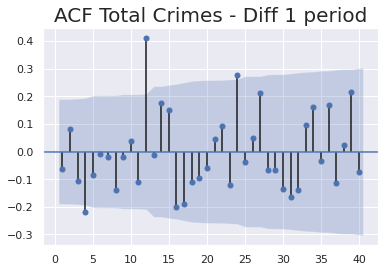

In [ ]:
sgt.plot_acf(dftotal_ts['Total Crimes'].diff(1).dropna(), lags = 40, zero=False)
plt.title('ACF Total Crimes - Diff 1 period', size=20)
plt.show()

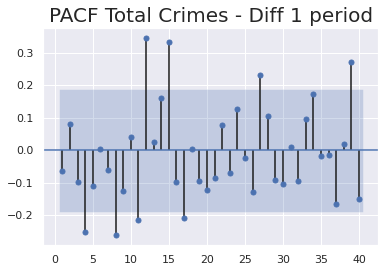

In [ ]:
sgt.plot_pacf(dftotal_ts['Total Crimes'].diff(1).dropna(), lags = 40, zero=False)
plt.title('PACF Total Crimes - Diff 1 period', size=20)
plt.show()

Examiniation of the auto-correlation factor of the transformed time series indicates there are significant factors at 4, 12, and 24 months. As we have observed seasonality, the seasonal trend at 12 months is likely a large part of the model.

In [ ]:
# Training and testing set
train_start = '2017-01-01'
train_end = '2019-01-01'
test_end = '2020-12-01'

train_data_trunc = dftotal_ts['Total Crimes'][train_start:train_end]
train_data = dftotal_ts['Total Crimes'][:train_end]
test_data = dftotal_ts['Total Crimes'][train_end:]

We will train the model using historical data until beginning of 2019, then test the model through 2019 and 2020

In [ ]:
#Use SARIMA since there is seasonal component 
my_order = (0,1,0) 
my_seasonal_order = (1,0,1,12) 

model_sarima = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
results_sarima = model_sarima.fit()
print(results_sarima.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



                                      SARIMAX Results                                       
Dep. Variable:                         Total Crimes   No. Observations:                   85
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -564.555
Date:                              Tue, 09 Mar 2021   AIC                           1135.109
Time:                                      19:26:32   BIC                           1142.401
Sample:                                  01-01-2012   HQIC                          1138.041
                                       - 01-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9663      0.074     13.057      0.000       0.821       1.111
ma.S.L12      -0.77

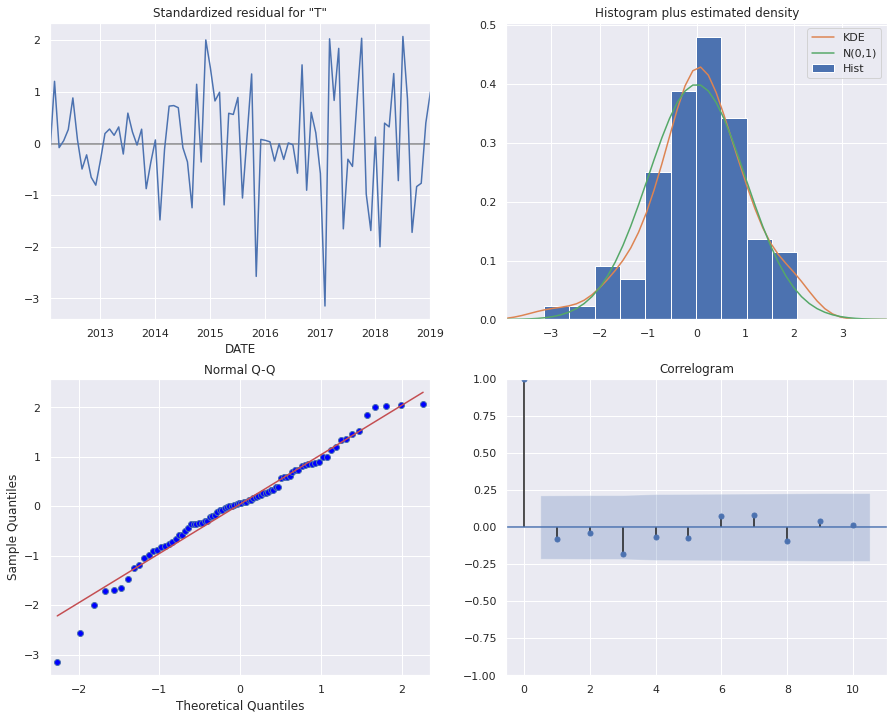

In [ ]:
results_sarima.plot_diagnostics(figsize = (15, 12))
plt.show()

Residuals appear to be white noise. 

Root Mean Squared Error (RMSE) : 433.17
Relative Error (%) : 0.17
RMSE 2019: 252.15
Rel err 2019: 0.08
RMSE 2020: 614.19
Rel err 2020: 0.27


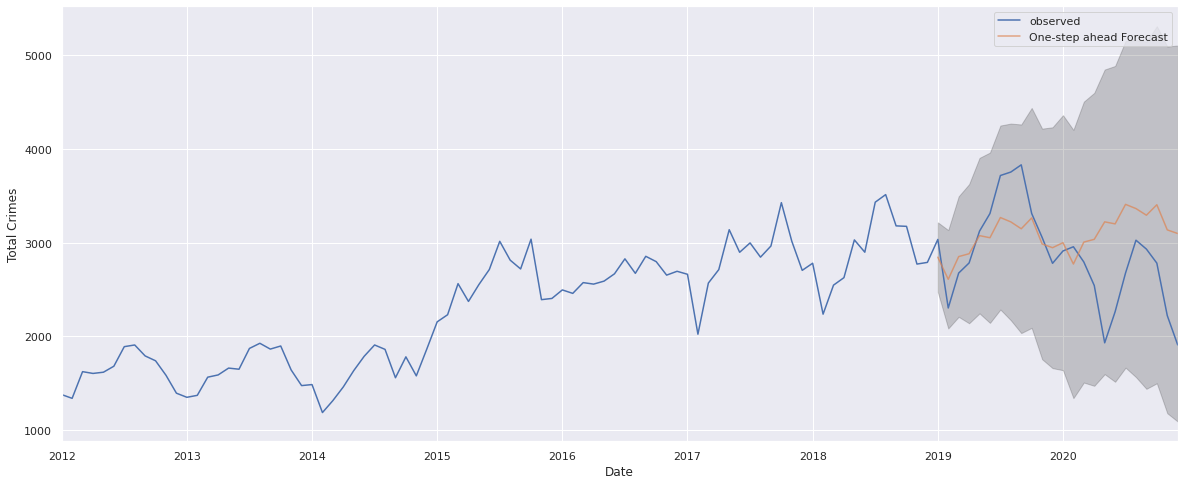

In [ ]:
# forecasting a confidence interval
pred = results_sarima.get_prediction(start=train_end, end=test_end, dynamic=True)
pred_ci = pred.conf_int()

ax = dftotal_ts['Total Crimes'][dftotal_ts.index[0]:].plot(label='observed', figsize=(20,8))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha = 0.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color='k', alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Crimes')
plt.legend()

y_forecasted = pred.predicted_mean
y_truth = dftotal_ts['Total Crimes'][train_end:]
# mean squared error
rmse = np.sqrt((y_forecasted - y_truth)**2).mean()
rel_err = (np.sqrt((y_forecasted - y_truth)**2)/y_truth).mean()
print('Root Mean Squared Error (RMSE) : {}'.format(round(rmse,2)))
print('Relative Error (%) : {}'.format(round(rel_err,2)))
rmse2019 = np.sqrt((y_forecasted['2019-01-01':'2019-12-01'] - y_truth['2019-01-01':'2019-12-01'])**2).mean()
rel_err2019 = (np.sqrt((y_forecasted['2019-01-01':'2019-12-01'] - y_truth['2019-01-01':'2019-12-01'])**2)/y_truth['2019-01-01':'2019-12-01']).mean()
print('RMSE 2019: {}'.format(round(rmse2019,2)))
print('Rel err 2019: {}'.format(round(rel_err2019,2)))
rmse2020 = np.sqrt((y_forecasted['2020-01-01':'2020-12-01'] - y_truth['2020-01-01':'2020-12-01'])**2).mean()
rel_err2020 = (np.sqrt((y_forecasted['2020-01-01':'2020-12-01'] - y_truth['2020-01-01':'2020-12-01'])**2)/y_truth['2020-01-01':'2020-12-01']).mean()
print('RMSE 2020: {}'.format(round(rmse2020,2)))
print('Rel err 2020: {}'.format(round(rel_err2020,2)))

While the SARIMA model did not fare too bad in 2019 (8% error), it performs worse in 2020 due to an overall shift in the decline trend (27% error). The overall trends are still within the 95% confidence interval of the model.

In [ ]:
#@title Fitting a SARIMAX Model - adding disorders
decompose(dftotal_ts['Total Disorders'])

In [ ]:
decompose(dftotal_ts['Total Disorders'].diff(1).dropna())

In [ ]:
test_stationarity(dftotal_ts['Total Disorders'].diff(1).dropna())

Results of Dicky-Fuller Test:
Test Statistic         -3.108334
p-value                 0.025943
# Lags Used            13.000000
# Observations Used    93.000000
dtype: float64
Time Series is stationary (@ 5%)


We will attempt to add Total Disorders as an exogenous variable to the SARIMA model to see if we can improve predictions. While there is still an overall trend, we will use the stationary first order difference as an exogenous variable to the SARIMA model.

In [ ]:
train_exog_trunc = dftotal_ts['Total Disorders'][train_start:train_end]
train_exog = dftotal_ts['Total Disorders'][:train_end]
test_exog = dftotal_ts['Total Disorders'][train_end:]

In [ ]:
train_exog.shape, test_exog.shape

((85,), (24,))

                                      SARIMAX Results                                       
Dep. Variable:                         Total Crimes   No. Observations:                   85
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -551.152
Date:                              Tue, 09 Mar 2021   AIC                           1110.305
Time:                                      19:20:21   BIC                           1120.028
Sample:                                  01-01-2012   HQIC                          1114.213
                                       - 01-01-2019                                         
Covariance Type:                                opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Total Disorders     0.2027      0.031      6.586      0.000       0.142       0.263
ar.S

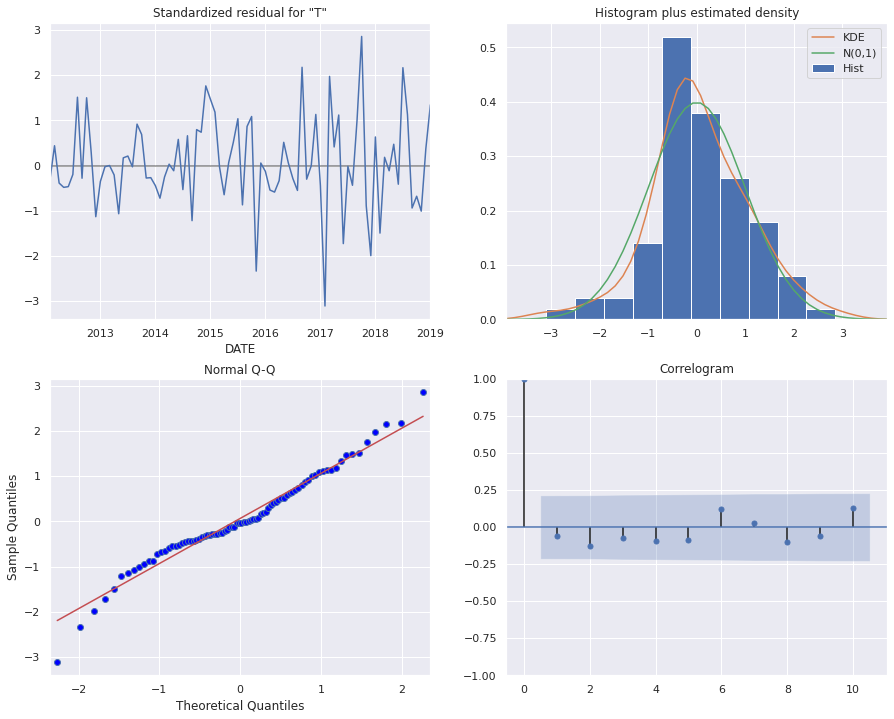

In [ ]:
#Use SARIMAX
my_order = (0,1,0) 
my_seasonal_order = (1,0,1,12) 

model_sarimax = SARIMAX(train_data, order=my_order, exog=train_exog, seasonal_order=my_seasonal_order)
results_sarimax = model_sarimax.fit()
print(results_sarimax.summary())
results_sarimax.plot_diagnostics(figsize = (15, 12))
plt.show()

The exogenous variable contribute to the model a significant amount. Residuals appear to be white noise, meaning no more trends can be extrapolated.

Root Mean Squared Error (RMSE) : 392.18
Relative Error (%) : 0.16
RMSE 2019: 229.61
Rel err 2019: 0.07
RMSE 2020: 554.74
Rel err 2020: 0.24


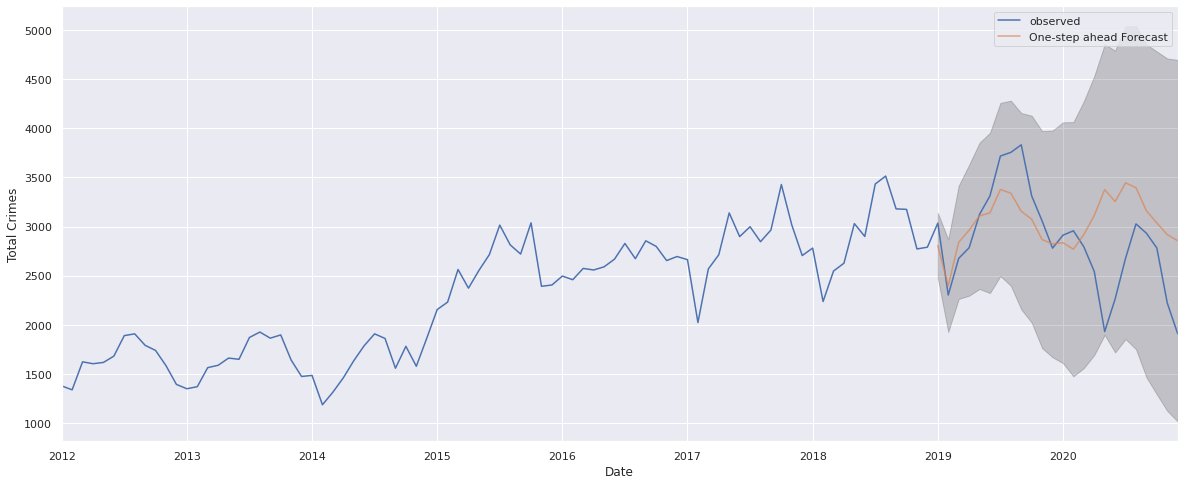

In [ ]:
predx = results_sarimax.get_prediction(start=train_end, end=test_end, dynamic=True,
                                       exog = test_exog[1:])
predx_ci = predx.conf_int()

ax = dftotal_ts['Total Crimes'][dftotal_ts.index[0]:].plot(label='observed', figsize=(20,8))
predx.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha = 0.7)

ax.fill_between(predx_ci.index,
                predx_ci.iloc[:,0],
                predx_ci.iloc[:,1],
                color='k', alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Crimes')
plt.legend()

y_forecasted = predx.predicted_mean
y_truth = dftotal_ts['Total Crimes'][train_end:]
# mean squared error
rmse = np.sqrt((y_forecasted - y_truth)**2).mean()
rel_err = (np.sqrt((y_forecasted - y_truth)**2)/y_truth).mean()
print('Root Mean Squared Error (RMSE) : {}'.format(round(rmse,2)))
print('Relative Error (%) : {}'.format(round(rel_err,2)))
rmse2019 = np.sqrt((y_forecasted['2019-01-01':'2019-12-01'] - y_truth['2019-01-01':'2019-12-01'])**2).mean()
rel_err2019 = (np.sqrt((y_forecasted['2019-01-01':'2019-12-01'] - y_truth['2019-01-01':'2019-12-01'])**2)/y_truth['2019-01-01':'2019-12-01']).mean()
print('RMSE 2019: {}'.format(round(rmse2019,2)))
print('Rel err 2019: {}'.format(round(rel_err2019,2)))
rmse2020 = np.sqrt((y_forecasted['2020-01-01':'2020-12-01'] - y_truth['2020-01-01':'2020-12-01'])**2).mean()
rel_err2020 = (np.sqrt((y_forecasted['2020-01-01':'2020-12-01'] - y_truth['2020-01-01':'2020-12-01'])**2)/y_truth['2020-01-01':'2020-12-01']).mean()
print('RMSE 2020: {}'.format(round(rmse2020,2)))
print('Rel err 2020: {}'.format(round(rel_err2020,2)))

There is an improvement of 1% in forecasting 2019 by adding Disorders as an exogenous variable, being able to catch the dip, but not the peak in 2019. 

Peaks and valleys in the 95% confidence intervals are much more pronounced with the MAX model vs no exogenous variable.

Again, the downward shift due to the pandemic makes it more difficult to forecast 2020.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                         Total Crimes   No. Observations:                   25
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -162.725
Date:                              Tue, 09 Mar 2021   AIC                            333.450
Time:                                      19:22:07   BIC                            338.162
Sample:                                  01-01-2017   HQIC                           334.700
                                       - 01-01-2019                                         
Covariance Type:                                opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Total Disorders     0.3523      0.097      3.638      0.000       0.162       0.542
ar.S

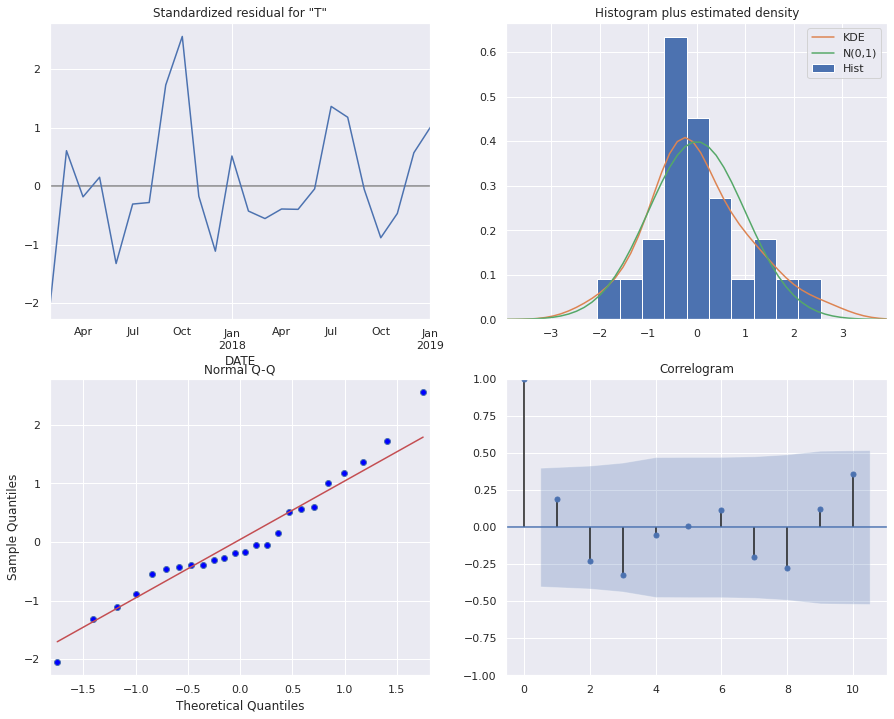

In [ ]:
# Try using only 2017 and 2018 data for training
my_order = (0,1,0) 
my_seasonal_order = (1,0,1,12) 

model_sarimax_trunc = SARIMAX(train_data_trunc, order=my_order, exog=train_exog_trunc, seasonal_order=my_seasonal_order)
results_sarimax_trunc = model_sarimax_trunc.fit()
print(results_sarimax_trunc.summary())
results_sarimax_trunc.plot_diagnostics(figsize = (15, 12))
plt.show()

Root Mean Squared Error (RMSE) : 424.08
Relative Error (%) : 0.17
RMSE 2019: 188.61
Rel err 2019: 0.06
RMSE 2020: 659.54
Rel err 2020: 0.29


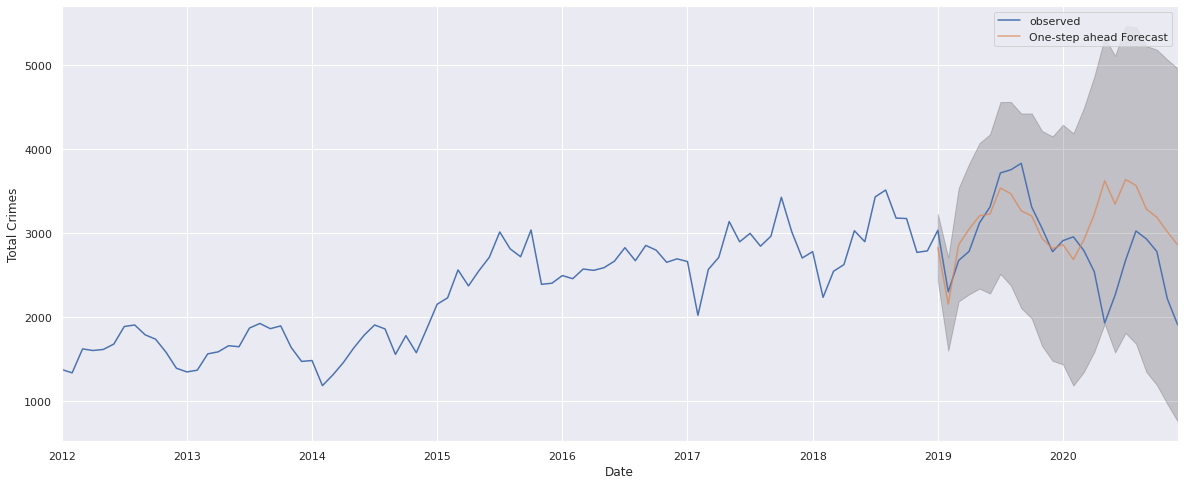

In [ ]:
predx = results_sarimax_trunc.get_prediction(start=train_end, end=test_end, dynamic=True,
                                       exog = test_exog[1:])
predx_ci = predx.conf_int()

ax = dftotal_ts['Total Crimes'][dftotal_ts.index[0]:].plot(label='observed', figsize=(20,8))
predx.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha = 0.7)

ax.fill_between(predx_ci.index,
                predx_ci.iloc[:,0],
                predx_ci.iloc[:,1],
                color='k', alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Crimes')
plt.legend()

y_forecasted = predx.predicted_mean
y_truth = dftotal_ts['Total Crimes'][train_end:]
# mean squared error
rmse = np.sqrt((y_forecasted - y_truth)**2).mean()
rel_err = (np.sqrt((y_forecasted - y_truth)**2)/y_truth).mean()
print('Root Mean Squared Error (RMSE) : {}'.format(round(rmse,2)))
print('Relative Error (%) : {}'.format(round(rel_err,2)))
rmse2019 = np.sqrt((y_forecasted['2019-01-01':'2019-12-01'] - y_truth['2019-01-01':'2019-12-01'])**2).mean()
rel_err2019 = (np.sqrt((y_forecasted['2019-01-01':'2019-12-01'] - y_truth['2019-01-01':'2019-12-01'])**2)/y_truth['2019-01-01':'2019-12-01']).mean()
print('RMSE 2019: {}'.format(round(rmse2019,2)))
print('Rel err 2019: {}'.format(round(rel_err2019,2)))
rmse2020 = np.sqrt((y_forecasted['2020-01-01':'2020-12-01'] - y_truth['2020-01-01':'2020-12-01'])**2).mean()
rel_err2020 = (np.sqrt((y_forecasted['2020-01-01':'2020-12-01'] - y_truth['2020-01-01':'2020-12-01'])**2)/y_truth['2020-01-01':'2020-12-01']).mean()
print('RMSE 2020: {}'.format(round(rmse2020,2)))
print('Rel err 2020: {}'.format(round(rel_err2020,2)))

In [ ]:
#@title Fitting Disorders with SARIMA Model

While useful for fitting models, exogenous data is normally not useful for predictions as it is difficult to forecast. Disorders to tend to behave in a more predictable manner, potentially making it a useful variable in a predictor of crime. 

In [ ]:
# Training and testing set
train_data_dis = dftotal_ts['Total Disorders'][:train_end]
test_data_dis = dftotal_ts['Total Disorders'][train_end:]

                                      SARIMAX Results                                       
Dep. Variable:                      Total Disorders   No. Observations:                   85
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -640.839
Date:                              Tue, 09 Mar 2021   AIC                           1287.678
Time:                                      19:43:09   BIC                           1294.970
Sample:                                  01-01-2012   HQIC                          1290.609
                                       - 01-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9829      0.035     27.841      0.000       0.914       1.052
ma.S.L12      -0.75

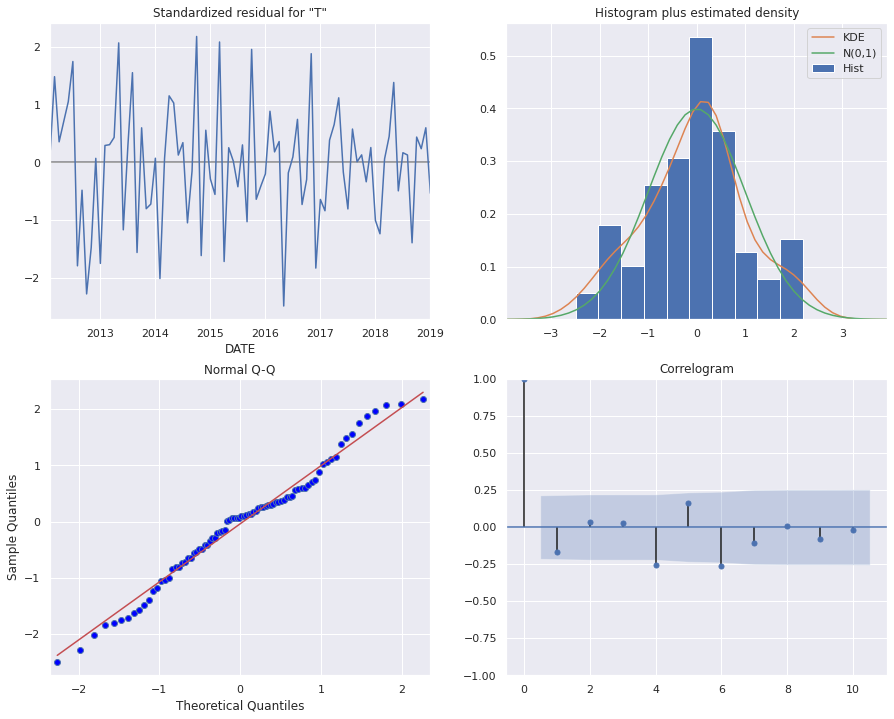

In [ ]:
#Use same basic SARIMA with first order differencing
my_order = (0,1,0) 
my_seasonal_order = (1,0,1,12) 

model_sarima_dis = SARIMAX(train_data_dis, order=my_order, seasonal_order=my_seasonal_order)
results_sarima_dis = model_sarima_dis.fit()
print(results_sarima_dis.summary())

results_sarima_dis.plot_diagnostics(figsize = (15, 12))
plt.show()

Root Mean Squared Error (RMSE) : 300.9
Relative Error (%) : 0.04


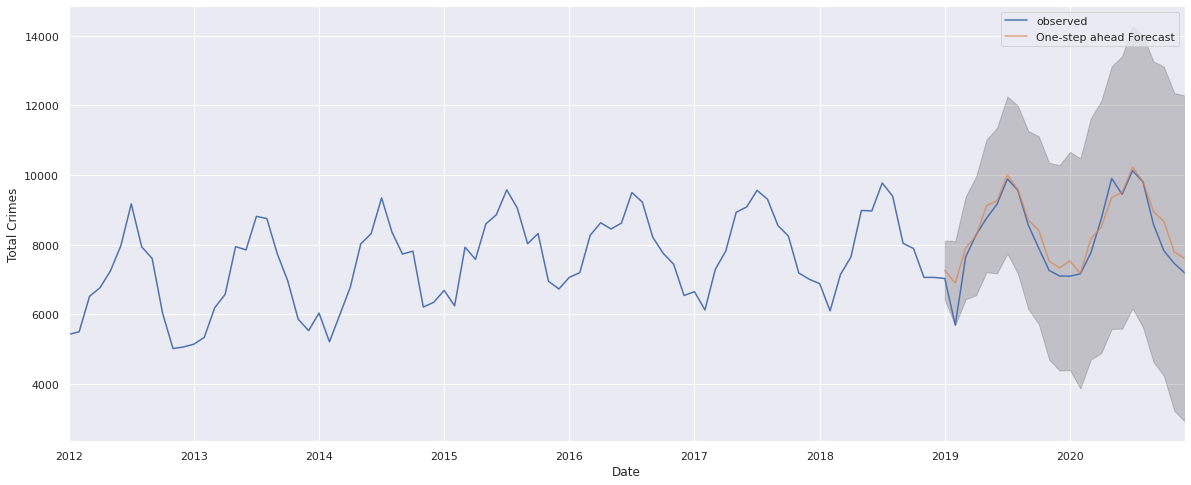

In [ ]:
# forecasting a confidence interval
pred_dis = results_sarima_dis.get_prediction(start=train_end, end=test_end, dynamic=True)
pred_dis_ci = pred_dis.conf_int()

ax = dftotal_ts['Total Disorders'][dftotal_ts.index[0]:].plot(label='observed', figsize=(20,8))
pred_dis.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha = 0.7)

ax.fill_between(pred_dis_ci.index,
                pred_dis_ci.iloc[:,0],
                pred_dis_ci.iloc[:,1],
                color='k', alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Crimes')
plt.legend()

y_forecasted = pred_dis.predicted_mean
y_truth = dftotal_ts['Total Disorders'][train_end:]
# mean squared error
rmse = np.sqrt((y_forecasted - y_truth)**2).mean()
rel_err = (np.sqrt((y_forecasted - y_truth)**2)/y_truth).mean()
print('Root Mean Squared Error (RMSE) : {}'.format(round(rmse,2)))
print('Relative Error (%) : {}'.format(round(rel_err,2)))

With a relative error of 4% over both 2019 and 2020, the model is able to forecast disorders a lot more reliably than crime.

In [ ]:
#@title Forecasting to the future

Crimes Forecast (model_sarimax) - ARMA(0,1,0), Seasonal (1,0,1,12), exogenous variable = Disorders

Disorders Forecast (model_sarima_dis) - ARMA(0,1,0), Seasonal (1,0,1,12) 

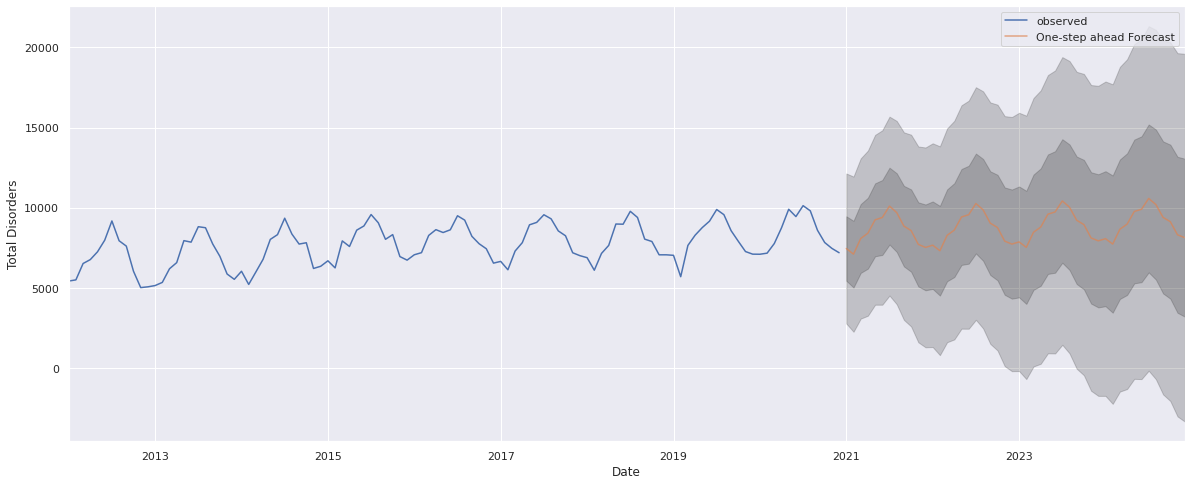

In [ ]:
# create 3 year forecast for disorders
forecast_start = '2021-01-01'
forecast_end = '2024-12-01'

forecast_dis = results_sarima_dis.get_prediction(start=forecast_start, end=forecast_end)
forecast_dis_ci_95 = forecast_dis.conf_int(alpha = 0.05)
forecast_dis_ci_60 = forecast_dis.conf_int(alpha = 0.40)

ax = dftotal_ts['Total Disorders'][dftotal_ts.index[0]:].plot(label='observed', figsize=(20,8))
forecast_dis.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha = 0.7)

ax.fill_between(forecast_dis_ci_95.index,
                forecast_dis_ci_95.iloc[:,0],
                forecast_dis_ci_95.iloc[:,1],
                color='k', alpha=0.2)

ax.fill_between(forecast_dis_ci_60.index,
                forecast_dis_ci_60.iloc[:,0],
                forecast_dis_ci_60.iloc[:,1],
                color='k', alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Disorders')
plt.legend()

In [ ]:
array1 = dftotal_ts['Total Disorders'][train_end:]
array1df = array1.to_frame()
array2 = forecast_dis.predicted_mean
array2df = array2.to_frame()
array2df.rename(columns={'predicted_mean':'Total Disorders'}, inplace=True)
df3 = array1df.append(array2df)

In [ ]:
ticklabels = dftotal_ts.index[0::12]
ticklabels = ticklabels.append(df3.index[24::12])

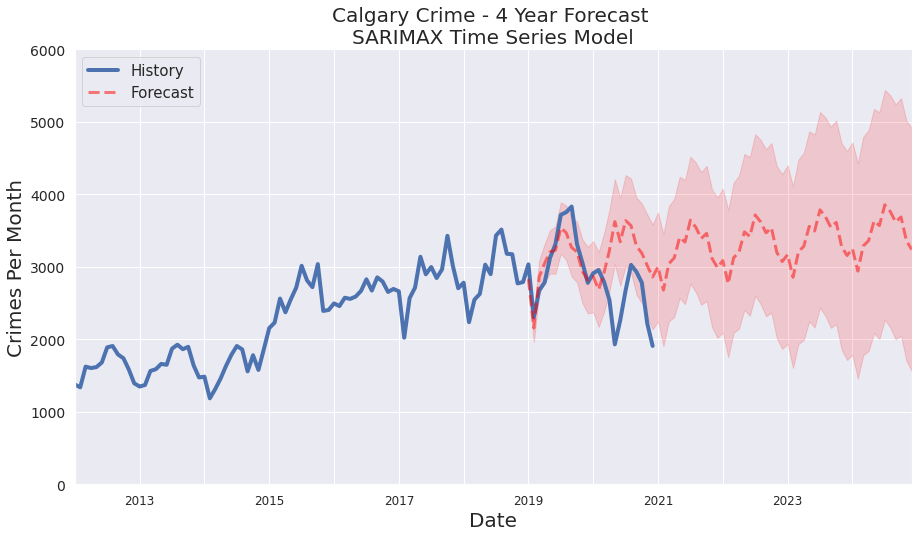

In [ ]:
#Final Forecast using SARIMAX model with exogenous variable as Disorders

predx = results_sarimax.get_prediction(start=train_end, end=forecast_end, dynamic=True,
                                       exog = df3['Total Disorders'][1:])
predx_ci = predx.conf_int(alpha=0.5)

ax = dftotal_ts['Total Crimes'][dftotal_ts.index[0]:].plot(label='History', figsize=(15,8), linewidth=4)
predx.predicted_mean.plot(ax=ax, label='Forecast', alpha = 0.5, 
                            linewidth=3, color='red', linestyle='dashed')

ax.fill_between(predx_ci.index,
                predx_ci.iloc[:,0],
                predx_ci.iloc[:,1],
                color='red', alpha=0.15)

plt.xticks(ticklabels, fontsize=12)
plt.yticks(fontsize=14)
plt.ylim([0,6000])

ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Crimes Per Month', fontsize=20)
plt.title('Calgary Crime - 4 Year Forecast \nSARIMAX Time Series Model', fontsize=20)
plt.legend(loc='upper left', fontsize = 15)


In [ ]:
# Using plotly
fig = go.Figure()
